In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/vibe/raw_data/twitter_MBTI.csv')

In [5]:
df = df[['text', 'label']]  # Keep only what's necessary
df.dropna(inplace=True)     # Drop rows with missing values

In [6]:
# Create one binary column for each MBTI letter
df['IE'] = df['label'].apply(lambda x: 1 if x[0] == 'i' else 0)
df['NS'] = df['label'].apply(lambda x: 1 if x[1] == 'n' else 0)
df['TF'] = df['label'].apply(lambda x: 1 if x[2] == 't' else 0)
df['JP'] = df['label'].apply(lambda x: 1 if x[3] == 'j' else 0)

In [7]:
import re

def clean_posts(text):
    # Sépare les tweets si concaténés par ||||
    tweets = text.split("||||")

    cleaned = []
    for tweet in tweets:
        # Supprime les mentions @utilisateur
        tweet = re.sub(r'@\w+', '', tweet)
        # Supprime les liens
        tweet = re.sub(r'http\S+', '', tweet)
        # Supprime les caractères non alphabétiques (en gardant les espaces)
        tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
        # Met en minuscules
        tweet = tweet.lower()
        # Supprime les espaces multiples
        tweet = re.sub(r'\s+', ' ', tweet).strip()
        cleaned.append(tweet)

    # Rejoint les tweets nettoyés en une seule chaîne
    return " ".join(cleaned)

In [8]:
df['clean_text'] = df['text'].apply(clean_posts)

In [9]:
df.head()

,text,label,IE,NS,TF,JP,clean_text
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj,1,1,1,1,the pope is infallible this is a catholic dogm...
1,@Hispanthicckk Being you makes you look cute||...,intj,1,1,1,1,being you makes you look cute on because then ...
2,@Alshymi Les balles sont réelles et sont tirée...,intj,1,1,1,1,les balles sont relles et sont tires trs rapid...
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj,1,1,1,1,im like entp but idiotichey boy do you want to...
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj,1,1,1,1,give it to he has pica since childhood say qub...


In [10]:
print(f"balance of the target ie : {df['IE'].value_counts(normalize=True)}")
print(f"balance of the target ns :{df['NS'].value_counts(normalize=True)}")
print(f"balance of the target tf :{df['TF'].value_counts(normalize=True)}")
print(f"balance of the target jp :{df['JP'].value_counts(normalize=True)}")

balance of the target ie : IE
1    0.671873
0    0.328127
Name: proportion, dtype: float64
balance of the target ns :NS
1    0.7725
0    0.2275
Name: proportion, dtype: float64
balance of the target tf :TF
0    0.588401
1    0.411599
Name: proportion, dtype: float64
balance of the target jp :JP
0    0.559083
1    0.440917
Name: proportion, dtype: float64


In [11]:
df['text_length_words'] = df['clean_text'].str.split().apply(len)

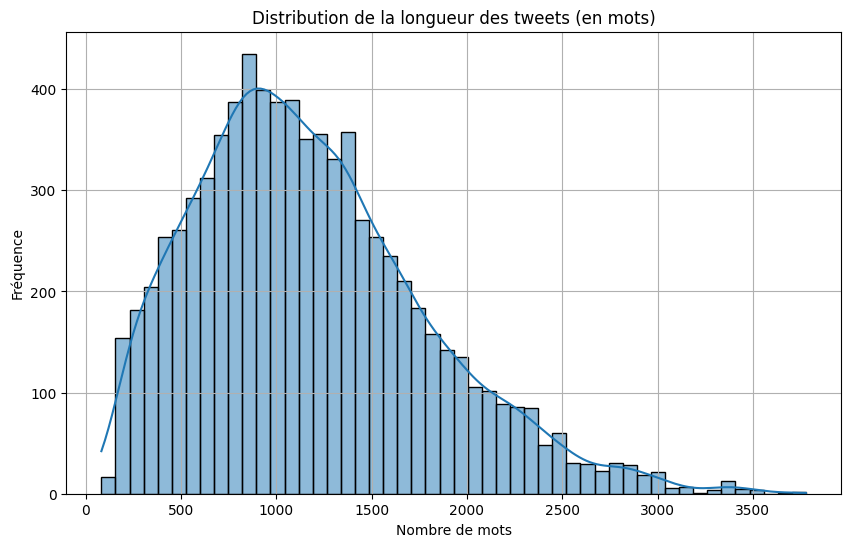

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length_words'], bins=50, kde=True)
plt.title("Distribution de la longueur des tweets (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

In [13]:
df = df[df['clean_text'].apply(lambda x: len(x.split()) < 1500 and len(x.split()) > 500)].reset_index(drop=True)

In [14]:
df.describe()

,IE,NS,TF,JP,text_length_words
count,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000
mean,0.664428,0.762434,0.405666,0.416999,996.609024
std,0.472240,0.425636,0.491072,0.493114,273.101713
min,0.000000,0.000000,0.000000,0.000000,501.000000
25%,0.000000,1.000000,0.000000,0.000000,774.000000
50%,1.000000,1.000000,0.000000,0.000000,989.000000
75%,1.000000,1.000000,1.000000,1.000000,1225.000000
max,1.000000,1.000000,1.000000,1.000000,1499.000000


In [15]:
df.head()

,text,label,IE,NS,TF,JP,clean_text,text_length_words
0,@Hispanthicckk Being you makes you look cute||...,intj,1,1,1,1,being you makes you look cute on because then ...,884
1,"I'm like entp but idiotic|||Hey boy, do you wa...",intj,1,1,1,1,im like entp but idiotichey boy do you want to...,916
2,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj,1,1,1,1,give it to he has pica since childhood say qub...,823
3,proud of this one it goes hard https://t.co/RQ...,intj,1,1,1,1,proud of this one it goes hard disgusting i am...,591
4,@Ieokuras so amazing!|||@hxhrats @ETTUKILLUG w...,intj,1,1,1,1,so amazing well mozart was a composer togashi ...,904


In [16]:
# tokenizer = AutoTokenizer.from_pretrained("nreimers/MiniLM-L6-H384-uncased")

In [17]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [18]:
def preproc(df, y):
  X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], y)
  X_train_tok = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors="tf", max_length=512)
  X_test_tok = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="tf", max_length=512)
  y_train_t = tf.constant(y_train, dtype=tf.int32)
  y_test_t = tf.constant(y_test, dtype=tf.int32)
  return X_train_tok, X_test_tok, y_train_t, y_test_t

In [19]:
from transformers import TFAutoModelForSequenceClassification, create_optimizer
from keras.losses import BinaryCrossentropy
import tensorflow as tf

In [20]:
X_train_tok, X_test_tok, y_train_t, y_test_t = preproc(df, df['TF'])

In [34]:
tf.expand_dims(y_train_t, axis=1)

<tf.Tensor: shape=(3573, 1), dtype=int32, numpy=
array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]], dtype=int32)>

In [39]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(X_train_tok), tf.cast(tf.expand_dims(y_train_t, axis=1), tf.float32)))
train_dataset = train_dataset.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((dict(X_test_tok), tf.cast(tf.expand_dims(y_test_t, axis=1), tf.float32)))
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [40]:
train_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [41]:
steps_per_epoch = len(X_train_tok) // 64

num_train_steps = steps_per_epoch * 10  # e.g. 10 epochs

optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=0
)

model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    from_pt=True,
    num_labels=1)

model.compile(
    optimizer=optimizer,
    loss=BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
    )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

In [42]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=5)

Epoch 1/5
56/56 [==============================] - 45s 452ms/step - loss: nan - accuracy: 0.5953 - val_loss: nan - val_accuracy: 0.5914
Epoch 2/5
56/56 [==============================] - 24s 422ms/step - loss: nan - accuracy: 0.5953 - val_loss: nan - val_accuracy: 0.5914
Epoch 3/5
56/56 [==============================] - 24s 421ms/step - loss: nan - accuracy: 0.5953 - val_loss: nan - val_accuracy: 0.5914
Epoch 4/5
56/56 [==============================] - 24s 421ms/step - loss: nan - accuracy: 0.5953 - val_loss: nan - val_accuracy: 0.5914
Epoch 5/5
56/56 [==============================] - 24s 421ms/step - loss: nan - accuracy: 0.5953 - val_loss: nan - val_accuracy: 0.5914


In [25]:
import matplotlib.pyplot as plt

# Plotting
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

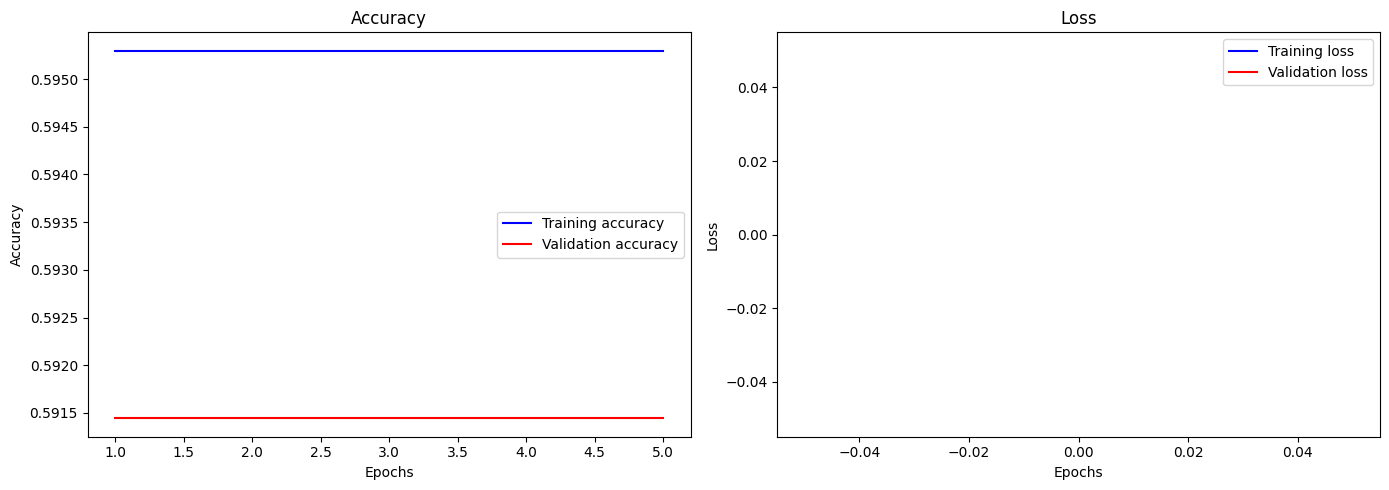

In [26]:
plot_training_history(history)

In [27]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [28]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66954241 (255.41 MB)
Trainable params: 66954241 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
y_train_t[:5]

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 0, 1, 0], dtype=int32)>

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])